# DBSCAN

* By Wai Ping Jerry KWOK
* Created on 2023-09-19

**Objective:**

Based on patient symptoms, categorize patients according to how urgently they need medical care, with particular importance placed on identifying all patients needing immediate resuscitation.

**Problem Statement:**

Triage is the prioritization of patient care (or victims during a disaster) based on illness/injury, symptoms, severity, prognosis, and resource availability. The purpose of triage is to identify patients needing immediate resuscitation, to help assign patients to a predesignated patient care area, and to initiate diagnostic/therapeutic measures as appropriate. Your job as a data scientist is to cluster the patients according to their symptoms and identify the level of urgency for each group; it is important to identify all patients needing immediate resuscitation.

# 1. Data

In [1]:
# import libraries for use
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import prettytable as pt
import joblib

# import sklearn for use
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

**a. Load *patient_priority.csv* into a pandas dataframe. Drop the 'triage' column and print out the header. Use *pandas.DataFrame.describe* to summarize the data. Using markdown, explain the meaning of each column and make observations about the dataset.**

In [2]:
# load the entire csv files as DataFrame using Pandas
df = pd.read_csv('patient_priority.csv', delimiter=',')

In [3]:
# drop the 'triage' column
df = df.drop(columns=['triage'])

In [4]:
# print out the header
df.head()

Unnamed: 0   age  gender  chest pain type  blood pressure  cholesterol  \
0           0  40.0     1.0              2.0           140.0        294.0   
1           1  49.0     0.0              3.0           160.0        180.0   
2           2  37.0     1.0              2.0           130.0        294.0   
3           3  48.0     0.0              4.0           138.0        214.0   
4           4  54.0     1.0              3.0           150.0        195.0   

   max heart rate  exercise angina  plasma glucose  skin_thickness  insulin  \
0           172.0              0.0           108.0            43.0     92.0   
1           156.0              0.0            75.0            47.0     90.0   
2           156.0              0.0            98.0            53.0    102.0   
3           156.0              1.0            72.0            51.0    118.0   
4           156.0              0.0           108.0            90.0     83.0   

    bmi  diabetes_pedigree  hypertension  heart_disease Residence_type  \
0  19.0           0.467386           0.0            0.0          Urban   
1  18.0           0.467386           0.0            0.0          Urban   
2  23.0           0.467386           0.0            0.0          Urban   
3  18.0           0.467386           0.0            0.0          Urban   
4  21.0           0.467386           0.0            0.0          Urban   

  smoking_status  
0   never smoked  
1   never smoked  
2   never smoked  
3   never smoked  
4   never smoked

In [5]:
# summarize the data
df.describe()

Unnamed: 0          age       gender  chest pain type  blood pressure  \
count  6962.000000  6962.000000  6961.000000      6962.000000     6962.000000   
mean   2011.954180    57.450014     0.531964         0.529015      109.629991   
std    1560.966466    11.904948     0.499013         1.253791       21.534852   
min       0.000000    28.000000     0.000000         0.000000       60.000000   
25%     604.000000    48.000000     0.000000         0.000000       92.000000   
50%    1628.500000    56.000000     1.000000         0.000000      111.000000   
75%    3368.750000    66.000000     1.000000         0.000000      127.000000   
max    5109.000000    82.000000     1.000000         4.000000      165.000000   

       cholesterol  max heart rate  exercise angina  plasma glucose  \
count  6962.000000     6962.000000      6962.000000     6962.000000   
mean    184.711290      163.502442         0.061764       98.394283   
std      32.010359       15.458693         0.240743       28.598084   
min     150.000000      138.000000         0.000000       55.120000   
25%     164.000000      150.000000         0.000000       78.707500   
50%     179.000000      163.000000         0.000000       93.000000   
75%     192.000000      177.000000         0.000000      111.632500   
max     294.000000      202.000000         1.000000      199.000000   

       skin_thickness      insulin          bmi  diabetes_pedigree  \
count     6962.000000  6962.000000  6962.000000        6962.000000   
mean        56.813416   111.091640    27.190908           0.467386   
std         22.889316    17.470033     7.362886           0.102663   
min         21.000000    81.000000    10.300000           0.078000   
25%         36.000000    97.000000    21.800000           0.467386   
50%         55.000000   111.000000    26.200000           0.467386   
75%         77.000000   125.000000    31.000000           0.467386   
max         99.000000   171.000000    66.800000           2.420000   

       hypertension  heart_disease  
count   6962.000000    6962.000000  
mean       0.071531       0.039500  
std        0.257729       0.194796  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.000000       0.000000  
75%        0.000000       0.000000  
max        1.000000       1.000000

In [6]:
# check the values of the column gender
df['gender'].unique()

array([ 1.,  0., nan])

In [7]:
# check the values of the column chest pain type
df['chest pain type'].unique()

array([2., 3., 4., 1., 0.])

In [8]:
# check the values of the column exercise angina
df['exercise angina'].unique()

array([0., 1.])

In [9]:
# check the values of the column hypertension
df['hypertension'].unique()

array([0., 1.])

In [10]:
# check the values of the column heart_disease
df['heart_disease'].unique()

array([0., 1.])

In [11]:
# check the values of the column Residence_type
df['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [12]:
# check the values of the column smoking_status
df['smoking_status'].unique()

array(['never smoked', 'smokes', 'formerly smoked', 'Unknown'],
      dtype=object)

**Observations**
* There are 6,962 instances in the dataset with 17 columns.
* Unnamed: 0 is for the identification of a patient, we should drop this information before analysis.
* We have both numerical and categorical features.
* The categorical features should be encoded before being put into the model.
* The features are in different scales. We should apply a scaler before fitting it into the model.
* It should be noted that chest pain type is already encoded and the scale from 0 to 4 may not necessarily be the strength of pain the patient experienced. 
* By looking at the data descriptions, we should discover that the features are about 3 types of life-threatening diseases.
1. Diabetes: plasma glucose, skin_thickness, insulin, diabetes_pedigree
2. High blood pressure: blood pressure, cholesterol, hypertension
3. Heart Disease: chest pain type, cholesterol, max heart rate, exercise angina, heart_disease

Data Descriptions
1. Unnamed: 0: integer, identification of the record
2. age: patient age
3. gender: patient gender, encoded to binary type in 0 or 1 
3. chest pain type: patient chest pain type, encoded in 0 to 4
4. blood pressure: patient blood pressure, numerical; normal range is less than 120 (systolic) and less than 80 (diastolic)
5. cholesterol: patient cholesterol, numerical; normal is less than 200 
6. max heart rate: maximum heart rate of the patient, numerical; it is 220 minus age.
7. exercise angina: patient exercise angina, encoded to binary type in 0 or 1; it is pain in the chest that comes on with exercise that makes the heart work harder. 
8. plasma glucose: patient's plasma glucose, numerical; this measure is for diagnostic of diabetes with normal range from 70 to 100 mg/dL.
9. skin_thickness: patient skin thickness, numerical; this measure is for diagnostic of diabetes for a long time.
10. insulin: patient insulin, numerical; this measure is for diagnostic of diabetes. It should be less than 25 under fasting.
11. bmi: patient BMI, numerical; normal range is 18.5 to 24.9.
12. diabetes_pedigree: patient diabetes pedigree, numerical; this measure is for diagnostic of diabetes based on family history.
13. hypertension: whether the patient has hypertension, encoded to binary type in 0 or 1; it means having high blood pressure
14. heart_disease: whether the patient has heart disease, encoded to binary type in 0 or 1
15. Residence_type: patient residence type, categorical
16. smoking_status: patient smoking status, categorical

In [13]:
# drop the Unnamed column
df.drop(columns=['Unnamed: 0'], inplace=True)

**b. Use *pandas.DataFrame.info* to check if the entries are the correct datatype, and if there are any missing values. Use *pandas.DataFrame.duplicates* to check for duplicate entries. Fix the dataset so that there are no missing values, duplicate rows, or incorrect data types. Use markdown to make observations and explain what you have done.**

In [14]:
# display the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6962 non-null   float64
 1   gender             6961 non-null   float64
 2   chest pain type    6962 non-null   float64
 3   blood pressure     6962 non-null   float64
 4   cholesterol        6962 non-null   float64
 5   max heart rate     6962 non-null   float64
 6   exercise angina    6962 non-null   float64
 7   plasma glucose     6962 non-null   float64
 8   skin_thickness     6962 non-null   float64
 9   insulin            6962 non-null   float64
 10  bmi                6962 non-null   float64
 11  diabetes_pedigree  6962 non-null   float64
 12  hypertension       6962 non-null   float64
 13  heart_disease      6962 non-null   float64
 14  Residence_type     6962 non-null   object 
 15  smoking_status     6962 non-null   object 
dtypes: float64(14), object(2

In [15]:
# check for duplicated values
df.duplicated().sum()

0

In [16]:
# check for missing values
df.isnull().sum().sort_values(ascending=False)

gender               1
age                  0
chest pain type      0
blood pressure       0
cholesterol          0
max heart rate       0
exercise angina      0
plasma glucose       0
skin_thickness       0
insulin              0
bmi                  0
diabetes_pedigree    0
hypertension         0
heart_disease        0
Residence_type       0
smoking_status       0
dtype: int64

**Obeservations**
1. All the data are numerical data except Residence_type and smoking_status.
2. There is no duplicated rows.
3. There is 1 entries with missing value in gender. We fill in the missing value with the mode from the feature using .fillna() and .mode()

In [17]:
# fill the missing values with mode
df['gender'].fillna(df['gender'].mode()[0], inplace=True)

In [18]:
# check for missing values
df.isnull().sum().sort_values(ascending=False)

age                  0
gender               0
chest pain type      0
blood pressure       0
cholesterol          0
max heart rate       0
exercise angina      0
plasma glucose       0
skin_thickness       0
insulin              0
bmi                  0
diabetes_pedigree    0
hypertension         0
heart_disease        0
Residence_type       0
smoking_status       0
dtype: int64

The missing values are fixed. There are no missing values, duplicate rows, or incorrect data types in the data set.

**c. Use *pandas.get_dummies* to one-hot-encode the two columns with string data.**

In [19]:
# select those features that are categorical
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Residence_type', 'smoking_status']

In [20]:
# one-hot encoding
ohc_df = pd.get_dummies(df, columns=categorical_features)

In [21]:
# display the header
ohc_df.head()

age  gender  chest pain type  blood pressure  cholesterol  max heart rate  \
0  40.0     1.0              2.0           140.0        294.0           172.0   
1  49.0     0.0              3.0           160.0        180.0           156.0   
2  37.0     1.0              2.0           130.0        294.0           156.0   
3  48.0     0.0              4.0           138.0        214.0           156.0   
4  54.0     1.0              3.0           150.0        195.0           156.0   

   exercise angina  plasma glucose  skin_thickness  insulin   bmi  \
0              0.0           108.0            43.0     92.0  19.0   
1              0.0            75.0            47.0     90.0  18.0   
2              0.0            98.0            53.0    102.0  23.0   
3              1.0            72.0            51.0    118.0  18.0   
4              0.0           108.0            90.0     83.0  21.0   

   diabetes_pedigree  hypertension  heart_disease  Residence_type_Rural  \
0           0.467386           0.0            0.0                 False   
1           0.467386           0.0            0.0                 False   
2           0.467386           0.0            0.0                 False   
3           0.467386           0.0            0.0                 False   
4           0.467386           0.0            0.0                 False   

   Residence_type_Urban  smoking_status_Unknown  \
0                  True                   False   
1                  True                   False   
2                  True                   False   
3                  True                   False   
4                  True                   False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                           False                         True   
1                           False                         True   
2                           False                         True   
3                           False                         True   
4                           False                         True   

   smoking_status_smokes  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False

**d. Use *seaborn.heatmap* to display the correlation matrix of the features. Use *seaborn.pairplot* to generate scatter plots and histograms. Use markdown to make observations.**

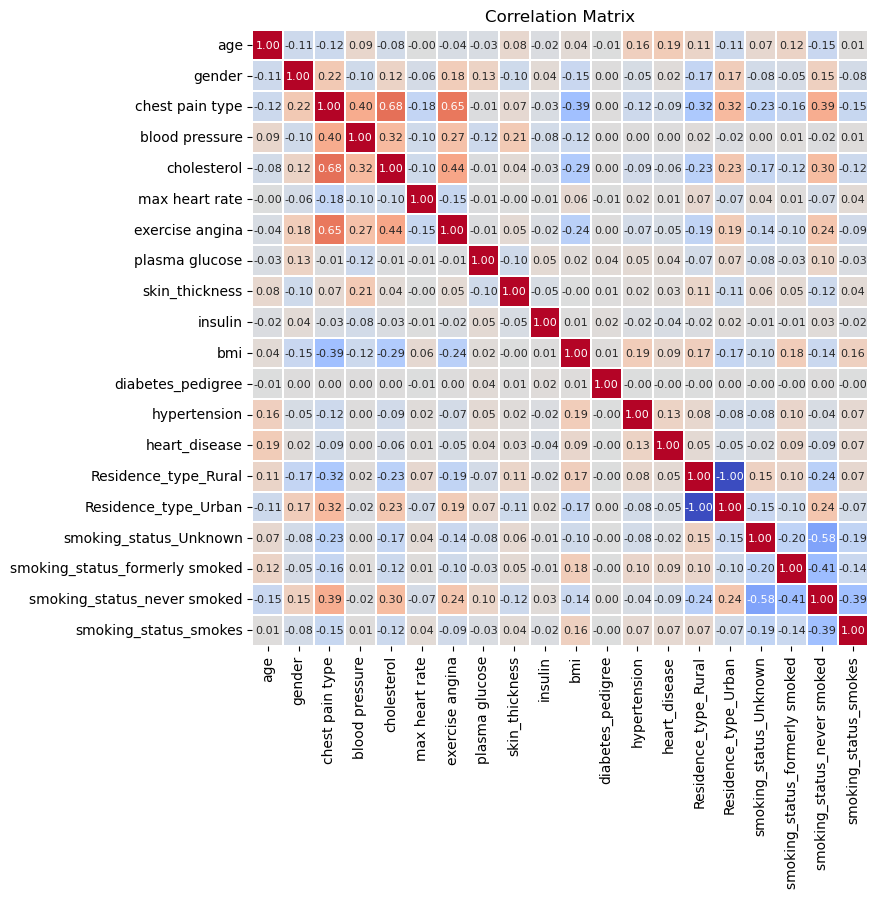

In [22]:
# display the correlation matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Correlation Matrix', fontsize=12)

sns.heatmap(data=ohc_df.corr(), 
            vmin=-1.0, 
            vmax=1.0, 
            cmap='coolwarm', 
            annot=True, annot_kws={"size": 8}, 
            fmt='.2f', 
            linewidths=0.1, 
            cbar=False, 
            square=True, 
            ax=ax)

plt.show()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Figure size 640x480 with 0 Axes>

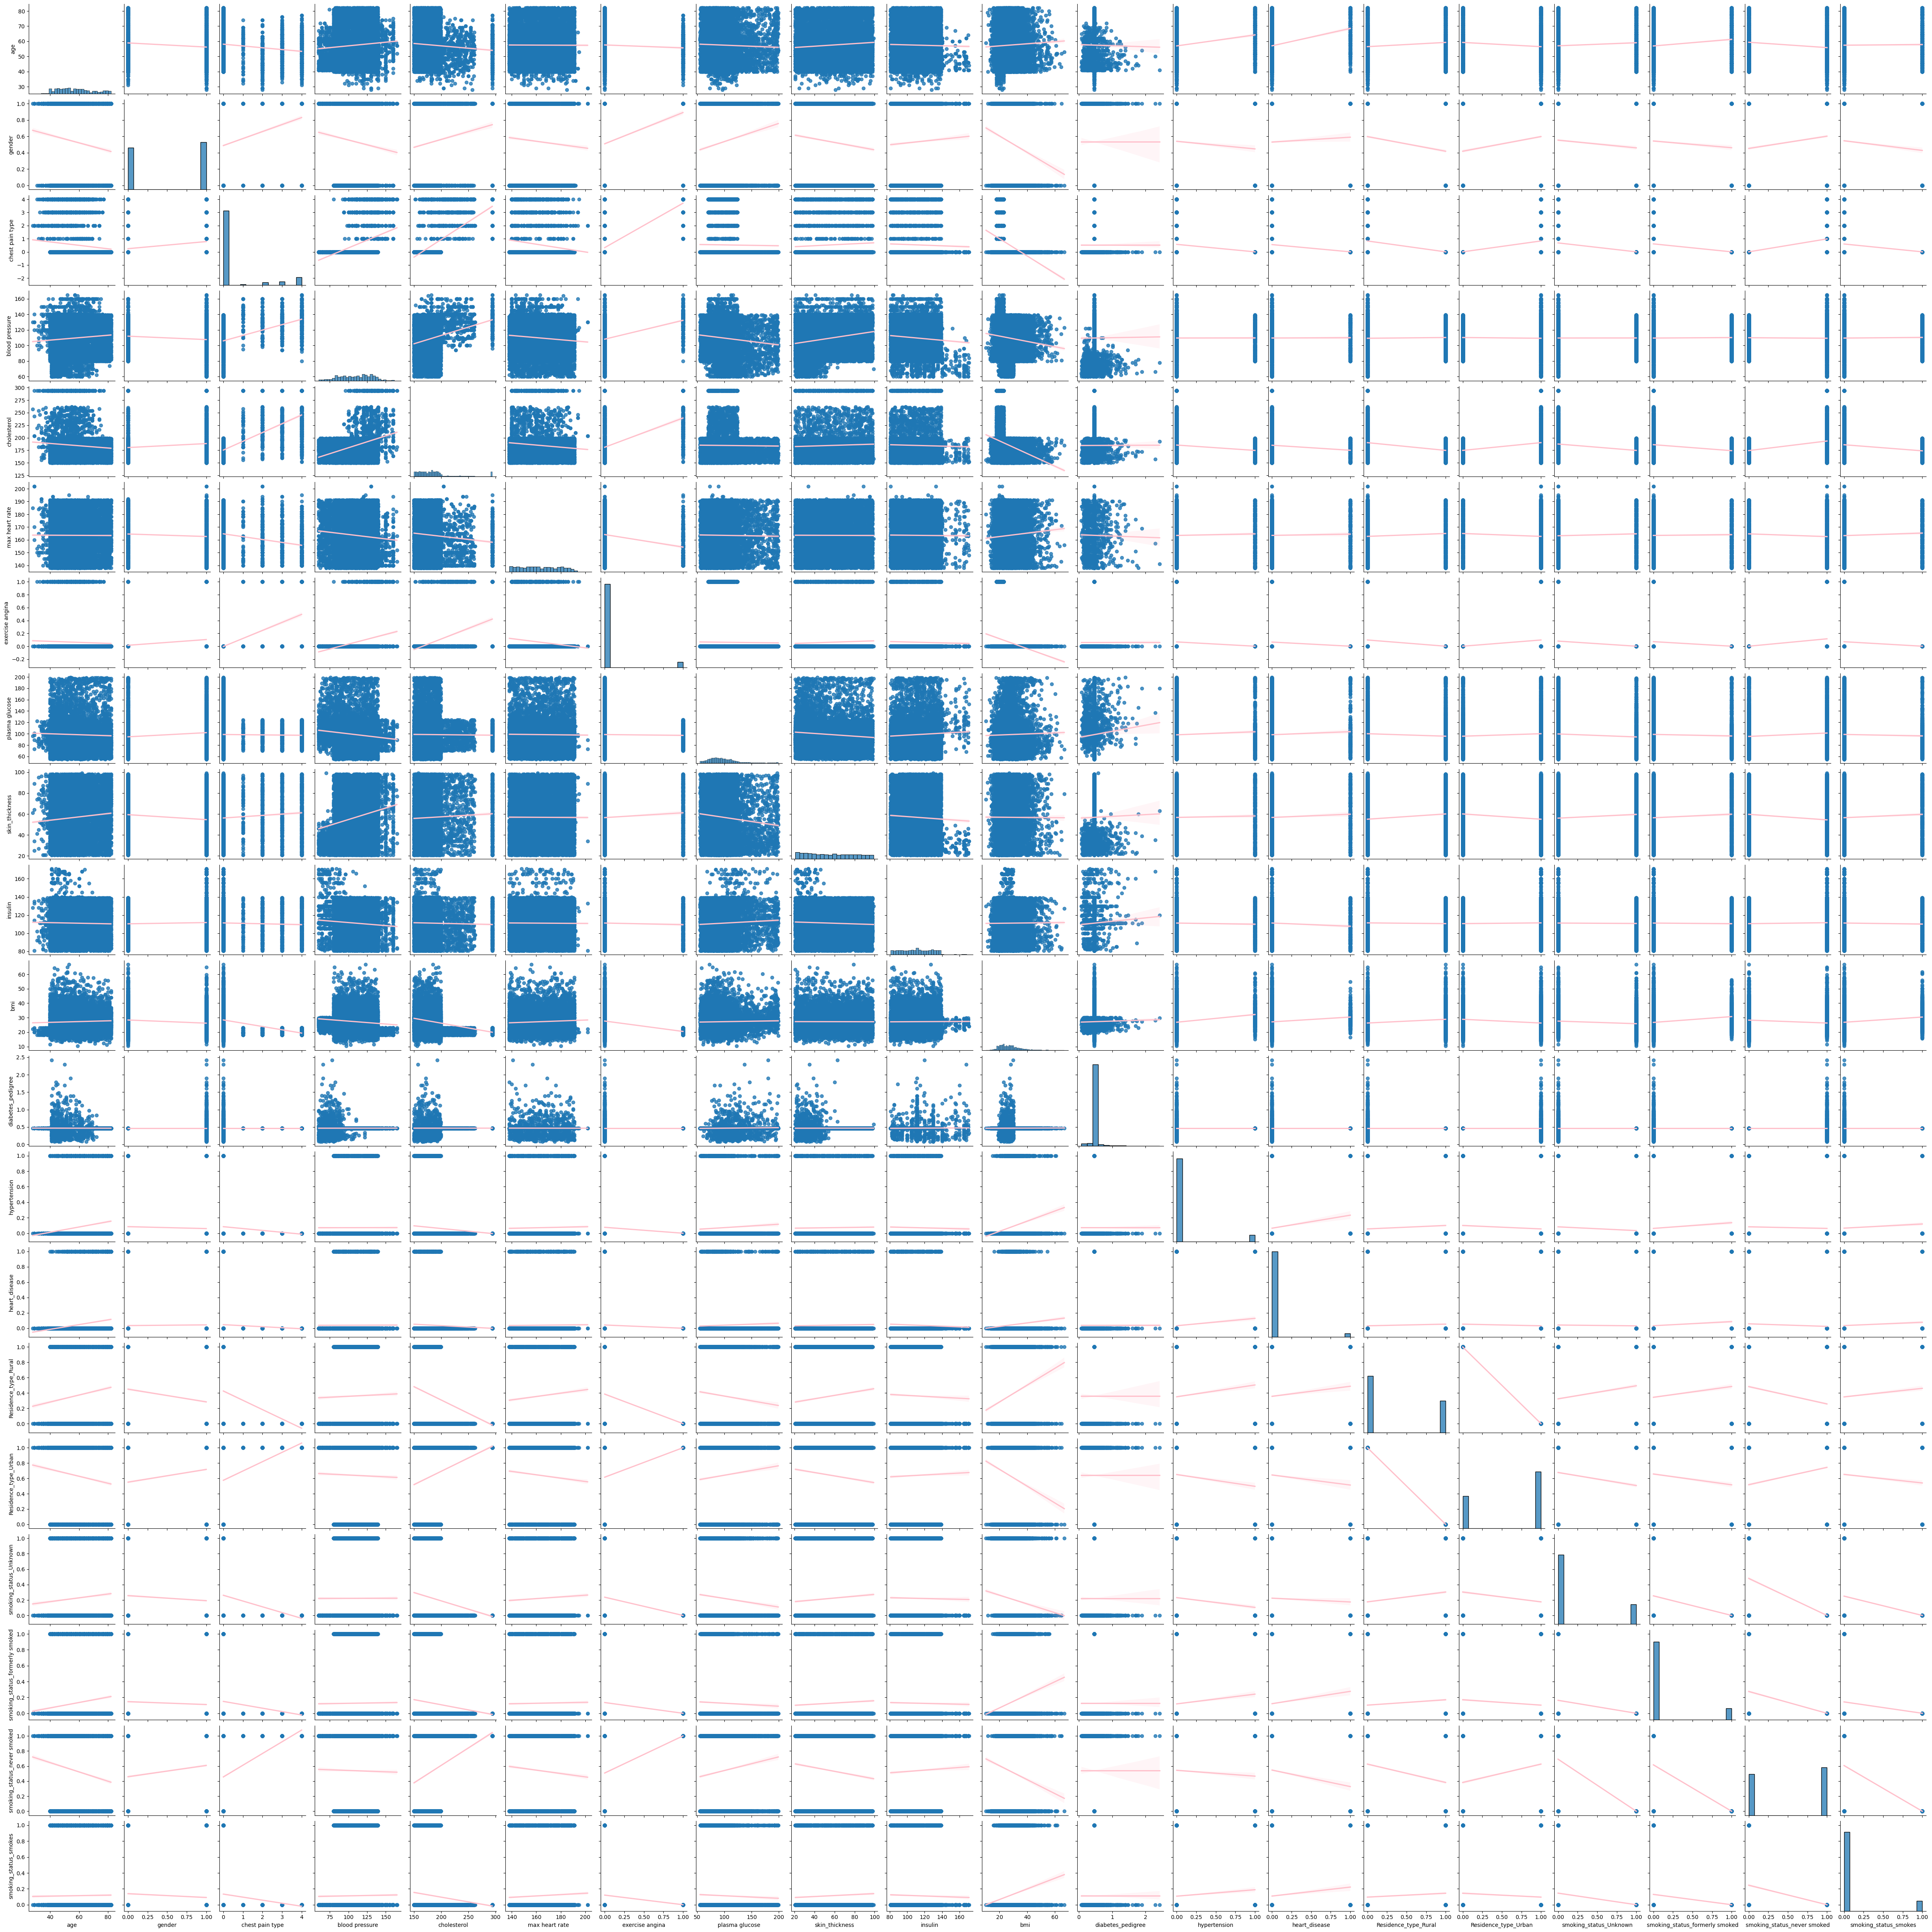

In [23]:
# display the pairplot using seaborn with a regression line
plt.figure()
sns.pairplot(ohc_df, 
             kind='reg', 
             plot_kws={'line_kws':{'color':'pink'}})
plt.show()

**Observations**
* The highest correlation is between cholesterol and chest pain type at 0.68. The next highest is between exercise angina and chest pain type at 0.65. 
* The feature chest pain type is also correlated with blood pressure at 0.40; smoking_status_never_smoked at 0.39; Residence_type_Urban at 0.32; and bmi at -0.39.
* These features do not have a strong correlation with other features, the correlation is around or less than 0.1: max heart rate, plasma glucose, insulin, and diabetes_pedigree. 
* From the scatterplot between numerical features, it is noted that there are some patterns already within the dataset. We should be aware that the dataset may have been processed by precedent users. 
* It should be noted that Residence_type and smoking_status are encoded features. The correlation in their own group of encoded features is expected to be high. 

Considering age and gender are two of the most convenient to obtain features, we may further check the data distribution in these areas.

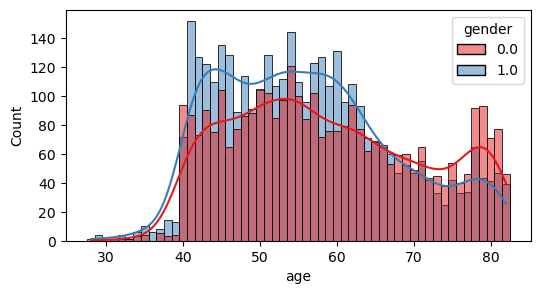

In [24]:
# plot age distribution with gender
fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(data=ohc_df, x='age', hue='gender', discrete=True, kde=True, palette='Set1', ax=ax)
plt.show()

**Observations:**
1. The majority of patients are from age 40 to 65. 
2. There is another peak of patients from age 78 to 81.
3. From the minimum age of 28 to 68, there are usually more patients in gender 1.
4. For age 40 and from age 68 onwards, there are more patients in gender 0.

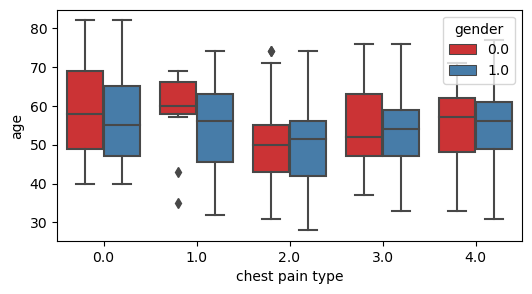

In [25]:
# plot age vs chest pain type
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=ohc_df, x='chest pain type', y='age', hue='gender', palette='Set1', ax=ax)
plt.show()

**Observations:**
1. From the boxplot, the mean age in different chest pain type groups is around 50 to 60.
2. Chest pain type 2 has the lowest mean age at about 50 for both genders.
3. Chest pain type 1 has the highest mean age at about 59 for gender 0. 
4. There are outliers in chest pain type 1 and chest pain type 2 for gender 0. Since these are health symptoms, we should not remove outliers. 

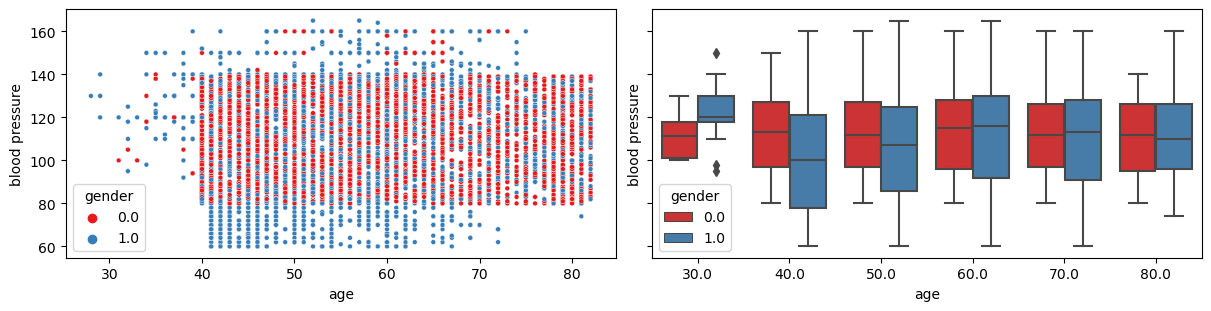

In [26]:
# plot blood pressure vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='blood pressure', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='blood pressure', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. The majority of patients are compacted inside the age range 40 to 85 and blood pressure ranges from 80 to 140 evenly.
3. For gender 0, all the patients are above 80 for blood pressure.
4. For gender 1, there is a group of patients with blood pressure from 60 to 80; but the age only ranged from 40 to 85.

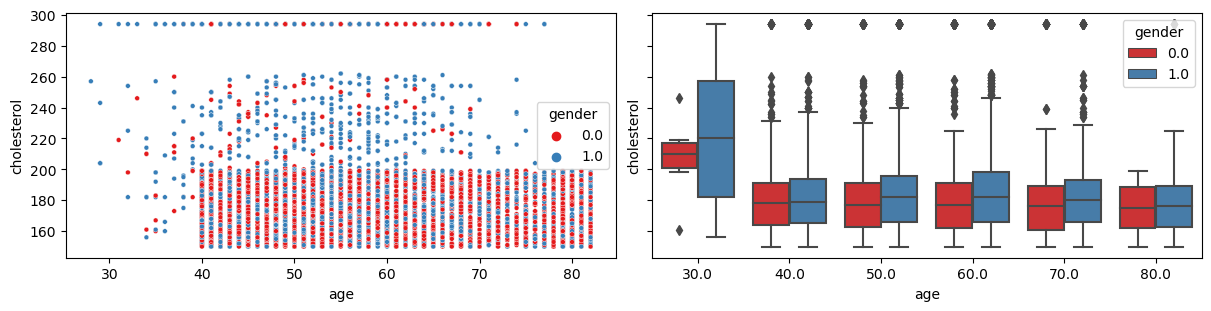

In [27]:
# plot cholesterol vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='cholesterol', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='cholesterol', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. The majority of patients are compacted inside the age range 40 to 85 and cholesterol ranges from 140 to 200 evenly.
3. There is a group of patients with a cholesterol level of 290, which is much higher than the majority group.

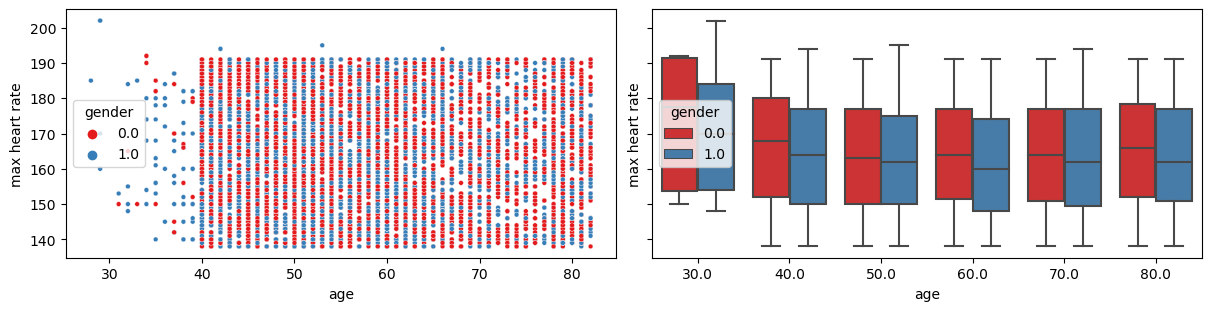

In [28]:
# plot max heart rate vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='max heart rate', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='max heart rate', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. The majority of patients are compacted inside the age range 40 to 85 and the max heart rate ranges from 135 to 190 evenly.

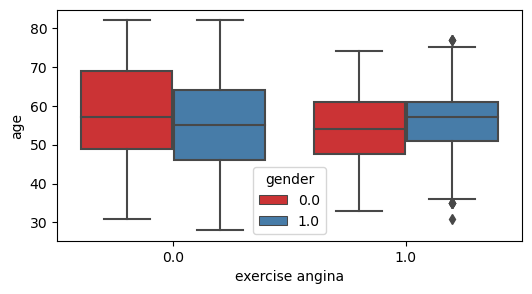

In [29]:
# plot age vs exercise angina
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=ohc_df, x='exercise angina', y='age', hue='gender', palette='Set1', ax=ax)
plt.show()

**Observations:**
1. From the box plot, there are fewer patients with exercise angina for both gender 0 and gender 1.
2. The mean age of having exercise angina is higher for gender 1 than that for gender 0.

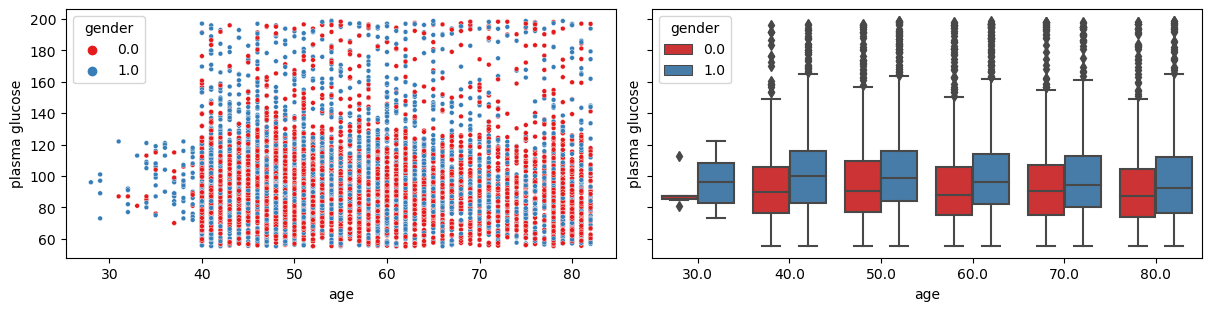

In [30]:
# plot plasma glucose vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='plasma glucose', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='plasma glucose', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. The majority of patients are compacted within the age range of 40 to 85 evenly.
3. There is a group of patients with age 28 to 40 but their plasma glucose only ranged from 70 to 120. 

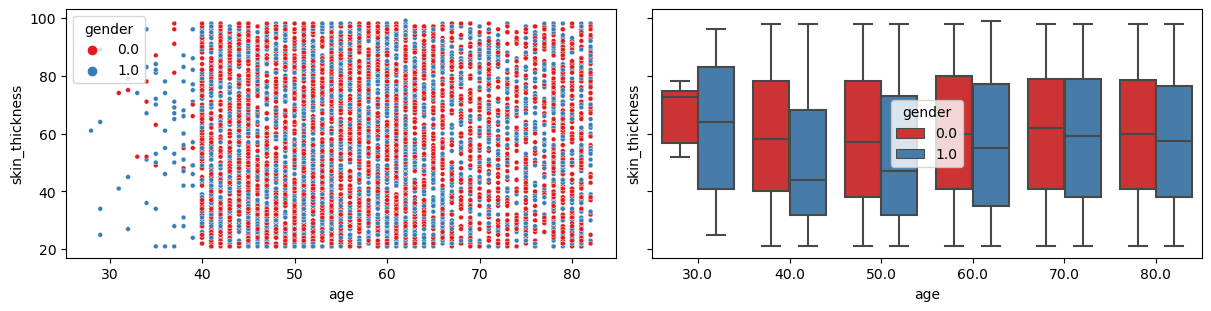

In [31]:
# plot skin_thickness vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='skin_thickness', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='skin_thickness', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. The majority of patients are compacted inside the age range 40 to 85 and skin thickness ranges from 20 to 100 evenly.

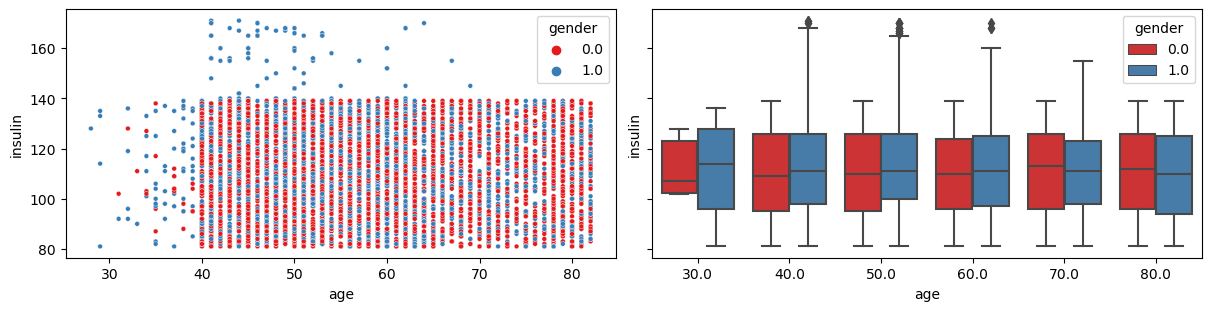

In [32]:
# plot insulin vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='insulin', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='insulin', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. The majority of patients are compacted inside the age range 40 to 85 and insulin range 80 to 140 evenly.
3. There is a group of gender 1 with insulin above 140 and age above 40.

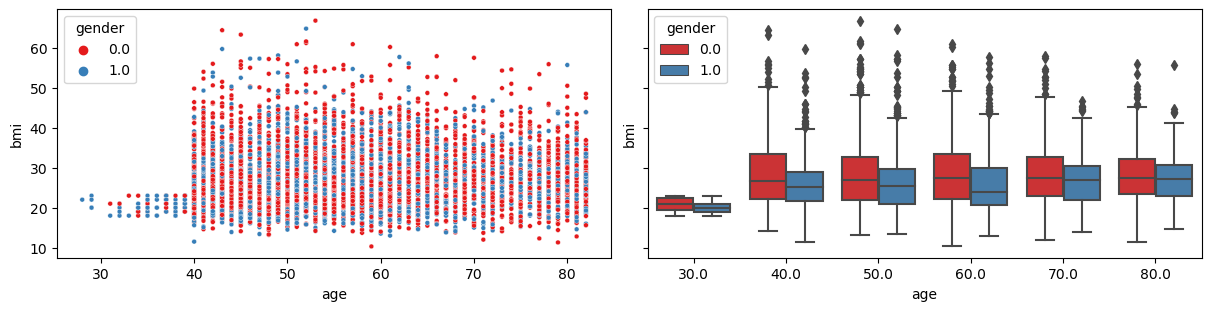

In [33]:
# plot bmi vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='bmi', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='bmi', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. The majority of patients are compacted inside the age range 40 to 85 and BMI range 18 to 35 evenly.
3. There is a group of patients with age under 40 and their BMIs are all under 25.

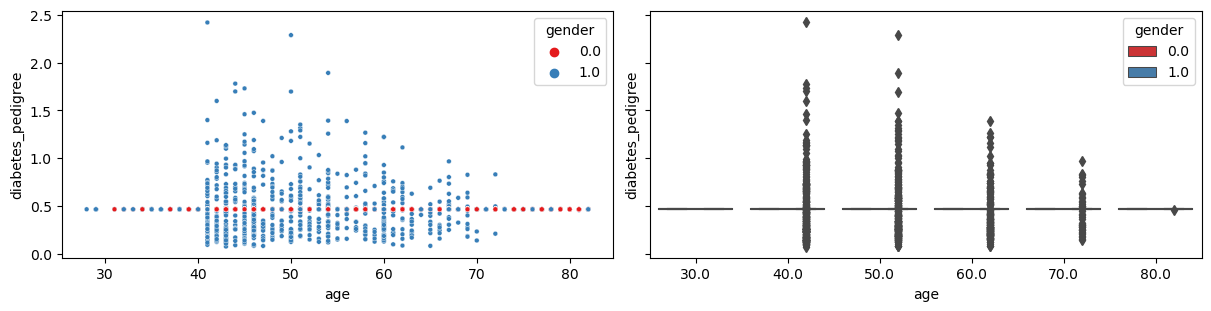

In [34]:
# plot diabetes_pedigree vs age
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,3), layout='constrained', sharey=True)
sns.scatterplot(data=ohc_df, x='age', y='diabetes_pedigree', hue='gender', palette='Set1', s=12, ax=ax1)
sns.boxplot(data=ohc_df, x=ohc_df['age'].round(-1), y='diabetes_pedigree', hue='gender', palette='Set1', ax=ax2)
plt.show()

**Observations:**
1. From the scatter plot, the data seems to be distorted. We should be cautious if the dataset is preprocessed. 
2. All patients with gender 0 have the same diabetes pedigree.
3. The majority of patients of gender 1 are compacted within the age range of 40 to 70.

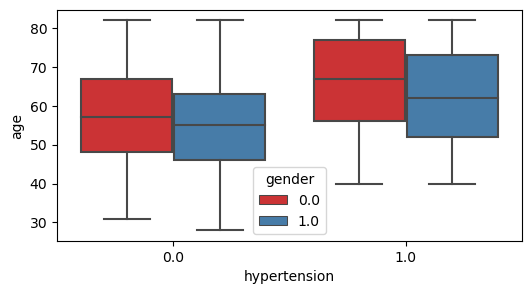

In [35]:
# plot age vs hypertension
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=ohc_df, x='hypertension', y='age', hue='gender', palette='Set1', ax=ax)
plt.show()

**Observations:**
1. From the box plot, the mean age of both gender 0 and gender 1 are higher for hypertension value 1.
2. For hypertension 1, gender 0 has a higher age than that of gender 1 in general.

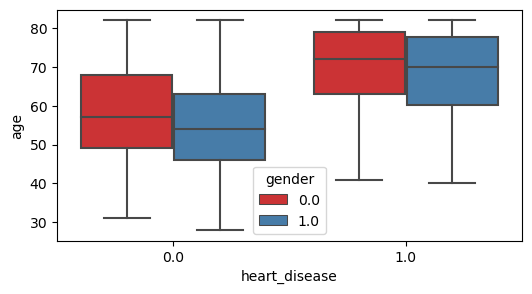

In [36]:
# plot age vs heart_disease
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=ohc_df, x='heart_disease', y='age', hue='gender', palette='Set1', ax=ax)
plt.show()

**Observations:**
1. From the box plot, the mean age of both gender 0 and gender 1 is higher for heart disease value 1.
2. For heart disease value 1, gender 0 has a slightly higher age than that of gender 1 in general.

From the above observations, we should keep in mind the dataset may be distorted. We should also note that the data packs evenly most of the time.

# 2. Modeling

**a. Use *sklearn.preprocessing.MinMaxScaler* to scale the data. Print the header.**

In [37]:
# scale data
scaler = MinMaxScaler()

# put the scaled data to a pd DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(ohc_df), columns=ohc_df.columns)

# print the header
df_scaled.head()

age  gender  chest pain type  blood pressure  cholesterol  \
0  0.222222     1.0             0.50        0.761905     1.000000   
1  0.388889     0.0             0.75        0.952381     0.208333   
2  0.166667     1.0             0.50        0.666667     1.000000   
3  0.370370     0.0             1.00        0.742857     0.444444   
4  0.481481     1.0             0.75        0.857143     0.312500   

   max heart rate  exercise angina  plasma glucose  skin_thickness   insulin  \
0         0.53125              0.0        0.367528        0.282051  0.122222   
1         0.28125              0.0        0.138171        0.333333  0.100000   
2         0.28125              0.0        0.298026        0.410256  0.233333   
3         0.28125              1.0        0.117320        0.384615  0.411111   
4         0.28125              0.0        0.367528        0.884615  0.022222   

        bmi  diabetes_pedigree  hypertension  heart_disease  \
0  0.153982           0.166262           0.0            0.0   
1  0.136283           0.166262           0.0            0.0   
2  0.224779           0.166262           0.0            0.0   
3  0.136283           0.166262           0.0            0.0   
4  0.189381           0.166262           0.0            0.0   

   Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
0                   0.0                   1.0                     0.0   
1                   0.0                   1.0                     0.0   
2                   0.0                   1.0                     0.0   
3                   0.0                   1.0                     0.0   
4                   0.0                   1.0                     0.0   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                             0.0                          1.0   
1                             0.0                          1.0   
2                             0.0                          1.0   
3                             0.0                          1.0   
4                             0.0                          1.0   

   smoking_status_smokes  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

**b. Use *sklearn.cluster.DBSCAN* to cluster the data. Create at least 10 different models with different choices for hyperparameters: *eps*, *min_samples*, *metric*, and *p*. Calculate the silhouette score for each and tabulate the results.**

**Discussion**

from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN
* eps : float, default=0.5 | The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.
* min_samples: int, default=5 | The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.
* metric: str, or callable, default='euclidean' | The metric to use when calculating distance between instances in a feature array. 
* p: float, default=None | The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2 (equivalent to the Euclidean distance).

To determine min_samples:
* It is based on the use case and context.
* A low min_samples will create clusters for outliers or noise.
* The larger the data set, the larger the value is recommended.
* The noisier the data set, the larger the value is recommended.
* The value should be greater than or equal to the dimensionality of the data set. The rule of thumb for problems with more than 2 dimensions is dim*2.

For this project
* The dimension is 16. We should use at least 32. 
* For patient triage, we may expect the highest priority group should be with the least number of patients. With reference from the National Center for Health Statistics of the U.S., about 2% of patients visit the emergency department and require immediate attention. Therefore, we may also consider 1.5% and 2% of 6962, which is 105 and 140.

Relationship of eps and min_samples
* min_samples in plain words is the minimum number of points required to form a dense region and eps is the radius of the circle within which the neighbouring points are considered part of the cluster.

After we determine the min_samples, we may use NearestNeighbors to find the optimal eps.

In [38]:
# setup some parameters for the NearestNeighbors model to find the epsilon value
# [min_samples, metric, p]
find_eps = {
    'combination_01': [105, 'euclidean', None],
    'combination_02': [140, 'euclidean', None],    
    'combination_03': [105, 'manhattan', None],
    'combination_04': [140, 'manhattan', None],    
    'combination_05': [105, 'chebyshev', None],
    'combination_06': [140, 'chebyshev', None],    
    'combination_07': [105, 'canberra', None],
    'combination_08': [140, 'canberra', None],    
    'combination_09': [105, 'braycurtis', None],
    'combination_10': [140, 'braycurtis', None],    
    'combination_11': [105, 'cosine', None],    
    'combination_12': [140, 'cosine', None],    
    'combination_13': [105, 'correlation', None],
    'combination_14': [140, 'correlation', None],    
    'combination_15': [105, 'minkowski', 10],
    'combination_16': [140, 'minkowski', 10]
}

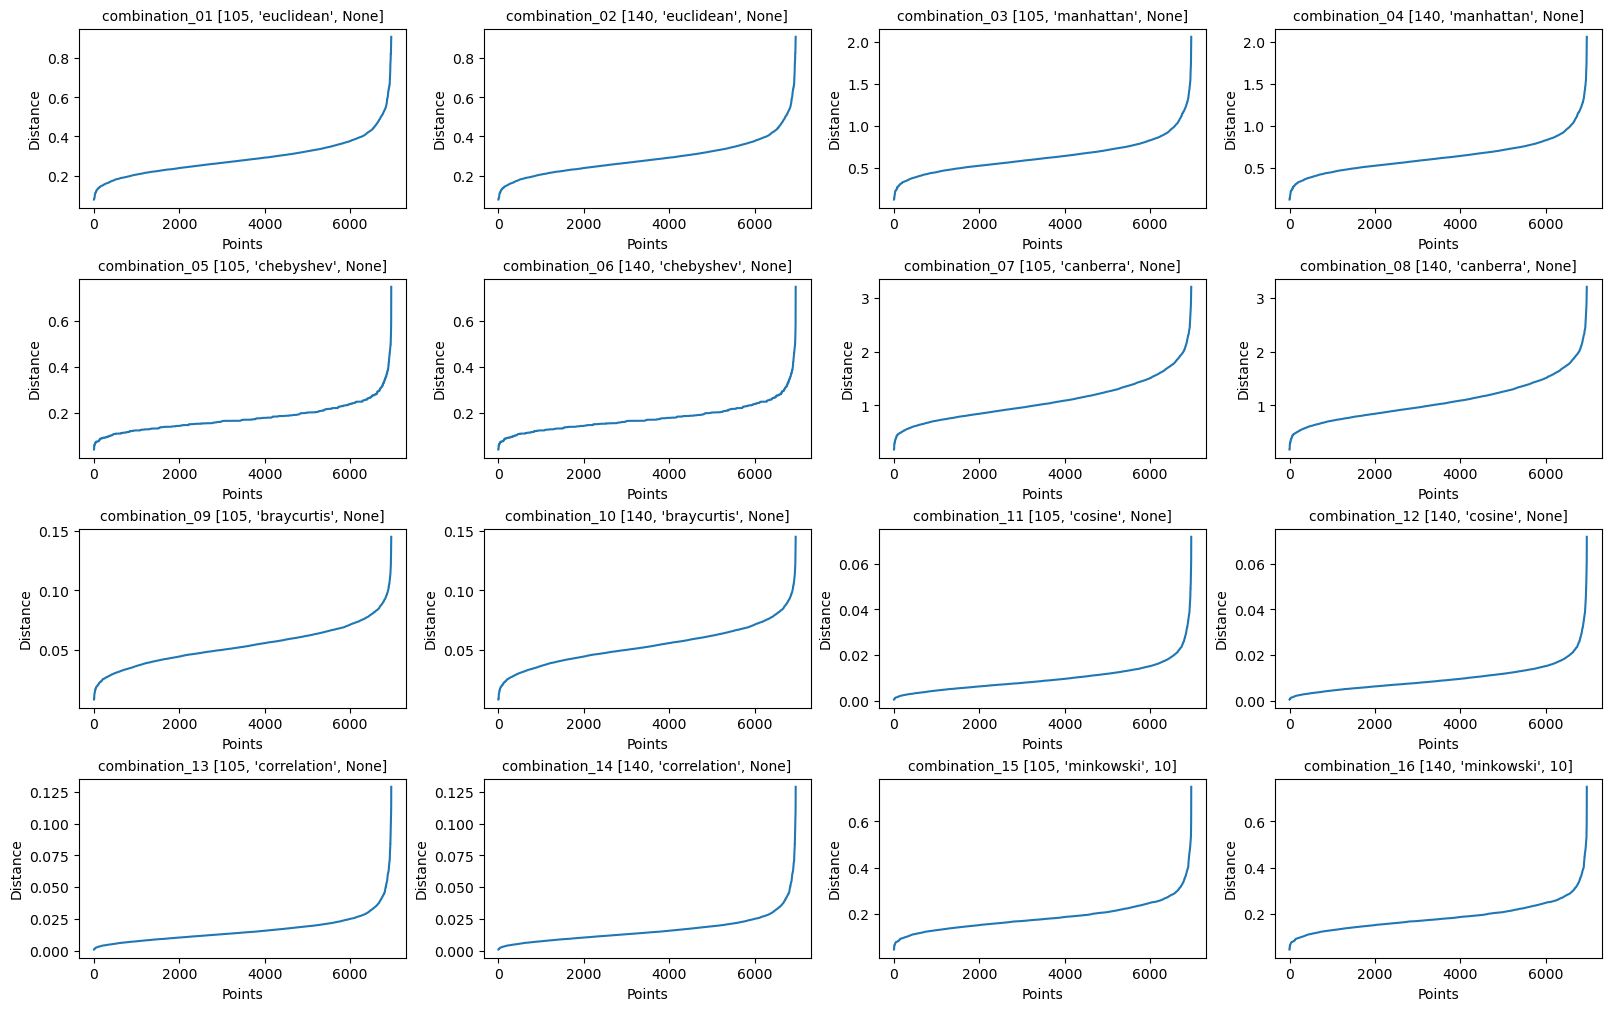

In [39]:
# plot the distance graph for each combination
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 10), layout='constrained')

i = 0
for ax in axs.flat:
    # get the key from models dict
    combination = list(find_eps.keys())[i]
    #for each combination in find_eps, find the distance using NearestNeighbors
    nn = NearestNeighbors(n_neighbors=find_eps[combination][0], 
                          metric=find_eps[combination][1], 
                          p=find_eps[combination][2]).fit(df_scaled)
    distances, indices = nn.kneighbors(df_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    # plot the distance graph
    ax.plot(distances)
    ax.set_title(f'{combination} {find_eps[combination]}', fontsize=10)
    ax.set_xlabel('Points')
    ax.set_ylabel('Distance')

    i += 1

By looking at the distance graph, we may estimate the best eps is around the value of the distance of the 'elbow'. An iterative process is used to find the desired eps.

Below process is to find the best epsilon value by repeatedly changing a and b for each combination and assessing the clusters with visualization.

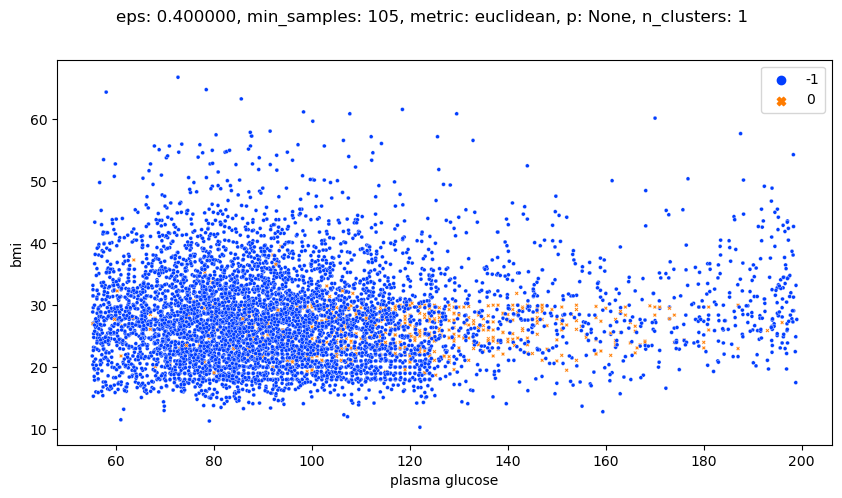

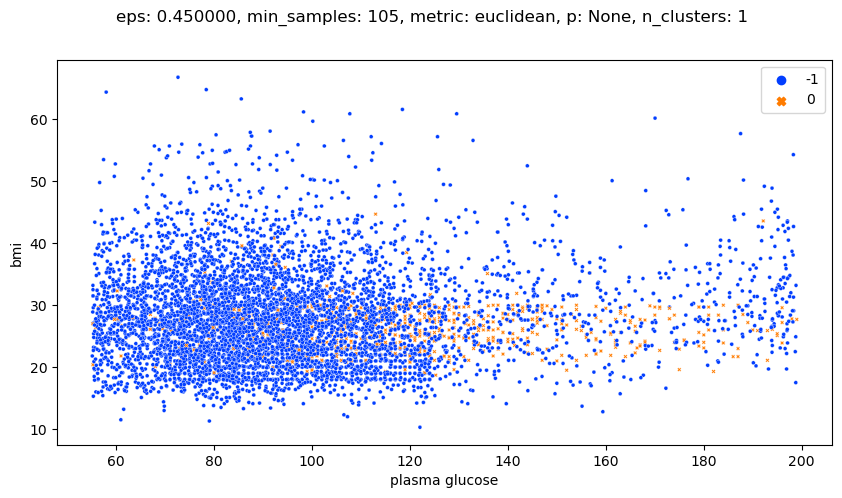

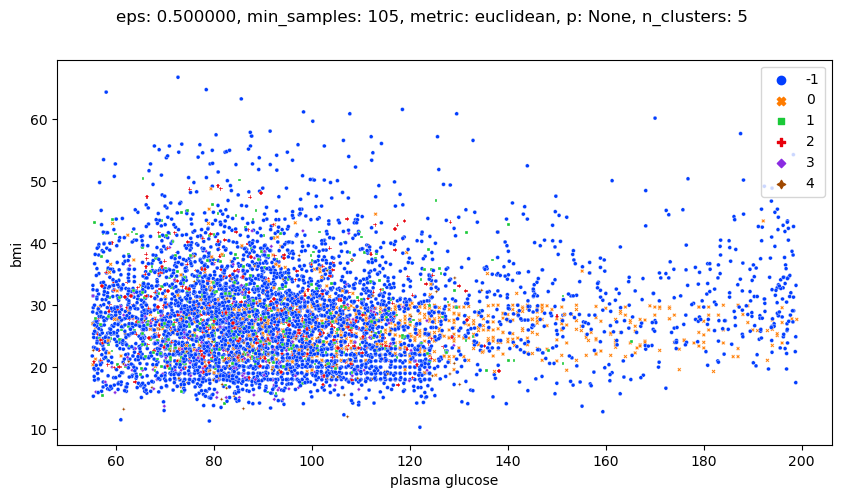

In [40]:
# a and b are the start and end value of the range of epsilon
a = 0.4
b = 0.5
# num_graph is the number of eps to plot
num_eps = 3
# min_samples, metric, p are the parameters from the NearestNeighbors model
min_samples = 105
metric = 'euclidean'
p = None
for i in range(num_eps):
    # linearly spaced between a and b
    eps = a + (b-a)*i/(num_eps-1) 
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, p=p).fit(df_scaled)
    labels = dbscan.labels_
    # calculate silhouette score
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters_ > 1:
        scores = silhouette_score(df_scaled, labels)
    # visualize the clusters
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(data=ohc_df, x=ohc_df['plasma glucose'], y=ohc_df['bmi'], hue=labels, style=labels, palette='bright', s=8, ax=ax)
    plt.suptitle(f'eps: {eps:.6f}, min_samples: {min_samples}, metric: {metric}, p: {p}, n_clusters: {n_clusters_}')
    plt.show()

After using the above codes repetitively, the eps is obtained and recorded. 

In [41]:
# build the models [min_samples, metric, p, eps]
all_models = {
    'model_01': [105, 'euclidean', None, 0.4867],
    'model_02': [140, 'euclidean', None, 0.5211],    
    'model_03': [105, 'manhattan', None, 1.3189],
    'model_04': [140, 'manhattan', None, 1.4333],    
    'model_05': [105, 'chebyshev', None, 0.3],
    'model_06': [140, 'chebyshev', None, 0.325],    
    'model_07': [105, 'canberra', None, 1.8333],
    'model_08': [140, 'canberra', None, 2.3778],    
    'model_09': [105, 'braycurtis', None, 0.12],
    'model_10': [140, 'braycurtis', None, 0.1356],    
    'model_11': [105, 'cosine', None, 0.0283],    
    'model_12': [140, 'cosine', None, 0.0328],    
    'model_13': [105, 'correlation', None, 0.0467],
    'model_14': [140, 'correlation', None, 0.055],    
    'model_15': [105, 'minkowski', 10, 0.3089],
    'model_16': [140, 'minkowski', 10, 0.3333]
}

In [42]:
# run the models, store the silhouette score and save the models
for model in all_models:
    dbscan = DBSCAN(eps=all_models[model][3], 
                    min_samples=all_models[model][0], 
                    metric=all_models[model][1], 
                    p=all_models[model][2]).fit(df_scaled)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters_ > 1:
        scores = silhouette_score(df_scaled, labels)
    all_models[model].append(scores)
    # save the model using joblib
    joblib.dump(dbscan, f'{model}.joblib')

In [43]:
# print out the result in a table
t = pt.PrettyTable(['Model', 'eps', 'min_samples', 'metric', 'p', 'silhouette_score'])
for k in all_models:
    t.add_row([k, 
               all_models[k][3], 
               all_models[k][0], 
               all_models[k][1], 
               all_models[k][2], 
               all_models[k][4]])
print(t)

+----------+--------+-------------+-------------+------+-----------------------+
|  Model   |  eps   | min_samples |    metric   |  p   |    silhouette_score   |
+----------+--------+-------------+-------------+------+-----------------------+
| model_01 | 0.4867 |     105     |  euclidean  | None |  -0.10024310209618388 |
| model_02 | 0.5211 |     140     |  euclidean  | None |  -0.09063046763658925 |
| model_03 | 1.3189 |     105     |  manhattan  | None |   0.1730204743736937  |
| model_04 | 1.4333 |     140     |  manhattan  | None |  0.20551181956776157  |
| model_05 |  0.3   |     105     |  chebyshev  | None |  -0.1010996579189966  |
| model_06 | 0.325  |     140     |  chebyshev  | None |  -0.08155801753654401 |
| model_07 | 1.8333 |     105     |   canberra  | None |  0.11647886991109463  |
| model_08 | 2.3778 |     140     |   canberra  | None |  0.12036534760264796  |
| model_09 |  0.12  |     105     |  braycurtis | None |  0.21069328575683904  |
| model_10 | 0.1356 |     14

**c. Select the best model for the use case and justify your choice in markdown.**

Using silhouette score as the criteria, model_10 is the best model because it has the highest silhouette score.

In [44]:
# load the best model 
best_model = joblib.load('model_10.joblib')
# get the labels
best_labels = best_model.labels_

**Discussions**

1. When clustering using DBSCAN, it may not be ideal to use silhouette score as the only criteria to choose the best model. 
2. We may consider other evaluation methods under https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
3. We should also consider the context and background of the problem that the data set is about.

# 3. Conclusions

**a. Based on your analysis in step 1, choose a pair of columns and generate a scatter plot of the data. Use the model predictions to colour the points according to the cluster they belong to. Use markdown to comment on the plot.**

From the analysis in Step 1, there are some features with outliers across the different ages. They include cholesterol, plasma glucose, insulin, and BMI. We would take plasma glucose and BMI from them to generate the scatter plot.

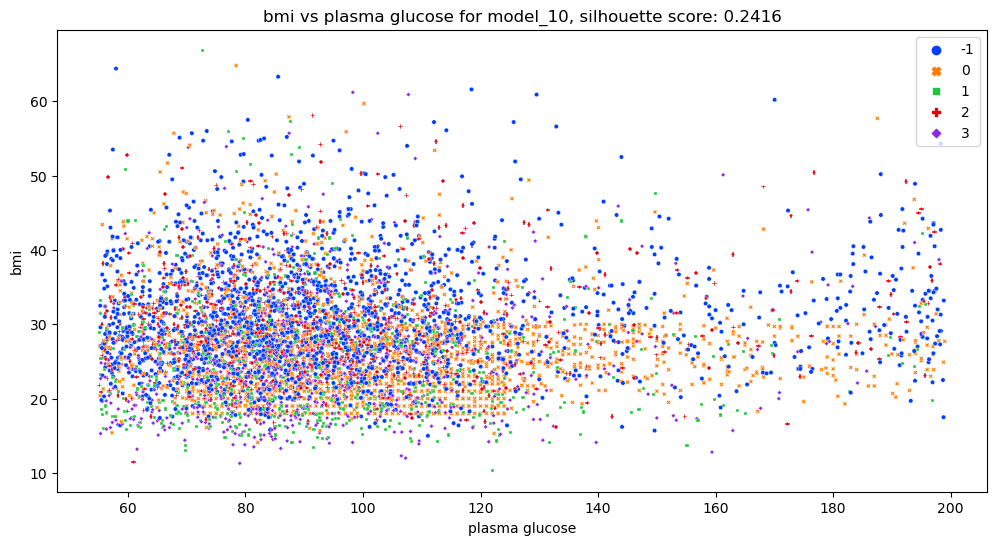

In [45]:
# visualize the clustering
fig, ax = plt.subplots(figsize=(12,6))

sns.scatterplot(data=ohc_df, x=ohc_df['plasma glucose'], y=ohc_df['bmi'], hue=best_labels, style=best_labels, palette='bright', s=10, ax=ax)

ax.set_title(f'bmi vs plasma glucose for model_10, silhouette score: {all_models["model_10"][4]:.4f}')
plt.show()

**Observations:**
1. Since we only take 2 features out of the 16 features to make a scatter plot, it is expected not to be able to see clusters clearly.
2. There is a large batch of Cluster 0 with plasma glucose ranging from 70 to 150 and BMI ranging from 18 to 30.
3. Some groups of Cluster 1 are around plasma glucose ranging from 65 to 110 and BMI ranging from 15 to 20.
4. Some groups of Cluster 3 are around plasma glucose ranging from 65 to 130 and BMI ranging from 12 to 18.

**b. Generate a histogram that shows the number of elements in each cluster. Use markdown to comment on the histogram.**

In [46]:
# create a new DataFrame to store the cluster labels
clustered_df = df

# add the cluster labels to the DataFrame
clustered_df['cluster'] = best_labels

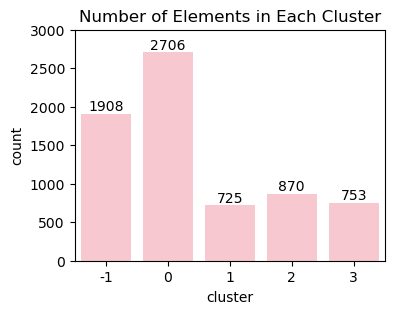

In [47]:
# generate a histogram to show the number of elements in each cluster
fig, ax = plt.subplots(figsize=(4,3))

sns.countplot(data=clustered_df, x='cluster', color='pink', ax=ax)

ax.set_title('Number of Elements in Each Cluster')
ax.set_ylim(0, 3000)
ax.bar_label(ax.containers[0])
plt.show()

**Observations**
1. There are 4 clusters. 
2. There are the most elements in Cluster 0. The count is 2706.
3. There are the least elements in Cluster 1. The count is 725.
4. There are 1908 elements identified as noise or outliers. They do not belong to any cluster.

**c. Create a separate dataframe for each cluster and use *pandas.DataFrame.describe* to describe each. Provide a written conclusion to describe each group of patients and rank the level of urgency.**

In [48]:
# create a new DataFrame for each cluster
cluster_0 = clustered_df[clustered_df['cluster'] == 0]
cluster_1 = clustered_df[clustered_df['cluster'] == 1]
cluster_2 = clustered_df[clustered_df['cluster'] == 2]
cluster_3 = clustered_df[clustered_df['cluster'] == 3]
cluster_x = clustered_df[clustered_df['cluster'] == -1]

In [49]:
# display the summary statistics for cluster 0
cluster_0.describe()      

age       gender  chest pain type  blood pressure  cholesterol  \
count  2706.000000  2706.000000      2706.000000     2706.000000  2706.000000   
mean     54.203622     0.698448         1.354398      109.073171   200.885070   
std      10.516404     0.459017         1.704743       26.750089    43.319316   
min      28.000000     0.000000         0.000000       60.000000   150.000000   
25%      46.000000     0.000000         0.000000       85.000000   170.000000   
50%      53.000000     1.000000         0.000000      113.000000   187.000000   
75%      61.000000     1.000000         3.000000      130.000000   220.000000   
max      82.000000     1.000000         4.000000      165.000000   294.000000   

       max heart rate  exercise angina  plasma glucose  skin_thickness  \
count     2706.000000      2706.000000     2706.000000     2706.000000   
mean       161.622690         0.158906      102.483030       52.439394   
std         15.136444         0.365656       26.680926       22.892827   
min        138.000000         0.000000       55.220000       21.000000   
25%        149.000000         0.000000       83.565000       32.000000   
50%        160.000000         0.000000       99.000000       47.000000   
75%        174.000000         0.000000      116.000000       73.000000   
max        202.000000         1.000000      199.000000       99.000000   

           insulin          bmi  diabetes_pedigree  hypertension  \
count  2706.000000  2706.000000        2706.000000   2706.000000   
mean    111.997413    24.865854           0.467386      0.017369   
std      18.232377     6.021383           0.164690      0.130665   
min      81.000000    14.100000           0.078000      0.000000   
25%      98.000000    21.000000           0.467386      0.000000   
50%     111.000000    23.000000           0.467386      0.000000   
75%     125.000000    27.800000           0.467386      0.000000   
max     171.000000    64.800000           2.420000      1.000000   

       heart_disease  cluster  
count    2706.000000   2706.0  
mean        0.007761      0.0  
std         0.087768      0.0  
min         0.000000      0.0  
25%         0.000000      0.0  
50%         0.000000      0.0  
75%         0.000000      0.0  
max         1.000000      0.0

In [50]:
# display the summary statistics for cluster 1
cluster_1.describe()

age      gender  chest pain type  blood pressure  cholesterol  \
count  725.000000  725.000000            725.0      725.000000   725.000000   
mean    58.215172    0.456552              0.0      110.451034   175.274483   
std     12.014749    0.498453              0.0       17.364134    14.967201   
min     40.000000    0.000000              0.0       80.000000   150.000000   
25%     48.000000    0.000000              0.0       96.000000   162.000000   
50%     57.000000    0.000000              0.0      110.000000   176.000000   
75%     67.000000    1.000000              0.0      126.000000   189.000000   
max     82.000000    1.000000              0.0      139.000000   199.000000   

       max heart rate  exercise angina  plasma glucose  skin_thickness  \
count      725.000000            725.0      725.000000      725.000000   
mean       165.295172              0.0       93.645986       60.339310   
std         15.257406              0.0       25.916875       22.143571   
min        138.000000              0.0       55.230000       21.000000   
25%        153.000000              0.0       76.120000       43.000000   
50%        166.000000              0.0       89.720000       60.000000   
75%        178.000000              0.0      107.550000       78.000000   
max        191.000000              0.0      196.910000       98.000000   

          insulin         bmi  diabetes_pedigree  hypertension  heart_disease  \
count  725.000000  725.000000       7.250000e+02    725.000000     725.000000   
mean   110.646897   25.254621       4.673860e-01      0.012414       0.017931   
std     17.056520    7.584245       1.277638e-15      0.110800       0.132792   
min     81.000000   10.300000       4.673860e-01      0.000000       0.000000   
25%     96.000000   19.200000       4.673860e-01      0.000000       0.000000   
50%    111.000000   24.100000       4.673860e-01      0.000000       0.000000   
75%    126.000000   29.400000       4.673860e-01      0.000000       0.000000   
max    139.000000   66.800000       4.673860e-01      1.000000       1.000000   

       cluster  
count    725.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

In [51]:
# display the summary statistics for cluster 2
cluster_2.describe() 

age      gender  chest pain type  blood pressure  cholesterol  \
count  870.000000  870.000000            870.0      870.000000   870.000000   
mean    59.083908    0.371264              0.0      110.168966   174.447126   
std     12.388089    0.483421              0.0       17.182168    14.247244   
min     40.000000    0.000000              0.0       80.000000   150.000000   
25%     49.000000    0.000000              0.0       95.000000   162.000000   
50%     57.000000    0.000000              0.0      111.000000   174.000000   
75%     68.750000    1.000000              0.0      125.000000   187.000000   
max     82.000000    1.000000              0.0      139.000000   199.000000   

       max heart rate  exercise angina  plasma glucose  skin_thickness  \
count      870.000000            870.0      870.000000      870.000000   
mean       165.621839              0.0       95.175747       60.666667   
std         15.232173              0.0       27.964799       22.133327   
min        138.000000              0.0       55.120000       21.000000   
25%        152.250000              0.0       75.425000       42.000000   
50%        166.000000              0.0       90.525000       62.000000   
75%        179.000000              0.0      107.427500       79.000000   
max        191.000000              0.0      198.240000       98.000000   

          insulin         bmi  diabetes_pedigree  hypertension  heart_disease  \
count  870.000000  870.000000       8.700000e+02     870.00000     870.000000   
mean   111.378161   29.414138       4.673860e-01       0.06092       0.020690   
std     16.634658    6.812178       1.277491e-15       0.23932       0.142425   
min     81.000000   11.500000       4.673860e-01       0.00000       0.000000   
25%     98.000000   24.725000       4.673860e-01       0.00000       0.000000   
50%    112.000000   28.400000       4.673860e-01       0.00000       0.000000   
75%    126.750000   33.000000       4.673860e-01       0.00000       0.000000   
max    139.000000   58.100000       4.673860e-01       1.00000       1.000000   

       cluster  
count    870.0  
mean       2.0  
std        0.0  
min        2.0  
25%        2.0  
50%        2.0  
75%        2.0  
max        2.0

In [52]:
# display the summary statistics for cluster 3
cluster_3.describe()

age      gender  chest pain type  blood pressure  cholesterol  \
count  753.000000  753.000000            753.0      753.000000   753.000000   
mean    59.517928    0.474104              0.0      108.788845   174.221780   
std     12.380708    0.499661              0.0       17.398850    14.477236   
min     40.000000    0.000000              0.0       80.000000   150.000000   
25%     50.000000    0.000000              0.0       92.000000   162.000000   
50%     58.000000    0.000000              0.0      109.000000   174.000000   
75%     70.000000    1.000000              0.0      124.000000   187.000000   
max     82.000000    1.000000              0.0      139.000000   199.000000   

       max heart rate  exercise angina  plasma glucose  skin_thickness  \
count      753.000000            753.0      753.000000      753.000000   
mean       164.706507              0.0       93.523201       59.520584   
std         15.720808              0.0       25.603263       21.738959   
min        138.000000              0.0       55.280000       21.000000   
25%        152.000000              0.0       76.630000       40.000000   
50%        164.000000              0.0       88.020000       59.000000   
75%        179.000000              0.0      105.340000       78.000000   
max        191.000000              0.0      198.020000       98.000000   

          insulin         bmi  diabetes_pedigree  hypertension  heart_disease  \
count  753.000000  753.000000       7.530000e+02    753.000000     753.000000   
mean   111.405046   25.644887       4.673860e-01      0.010624       0.015936   
std     16.933437    7.958630       1.277605e-15      0.102593       0.125312   
min     81.000000   11.300000       4.673860e-01      0.000000       0.000000   
25%     97.000000   19.500000       4.673860e-01      0.000000       0.000000   
50%    112.000000   24.500000       4.673860e-01      0.000000       0.000000   
75%    127.000000   30.400000       4.673860e-01      0.000000       0.000000   
max    139.000000   61.200000       4.673860e-01      1.000000       1.000000   

       cluster  
count    753.0  
mean       3.0  
std        0.0  
min        3.0  
25%        3.0  
50%        3.0  
75%        3.0  
max        3.0

In [53]:
# display the summary statistics for noise
cluster_x.describe()

age       gender  chest pain type  blood pressure  cholesterol  \
count  1908.000000  1908.000000      1908.000000     1908.000000  1908.000000   
mean     60.202306     0.420860         0.009434      110.193920   174.178721   
std      12.231981     0.493826         0.185796       17.549693    14.515060   
min      35.000000     0.000000         0.000000       80.000000   150.000000   
25%      50.000000     0.000000         0.000000       95.000000   162.000000   
50%      59.000000     0.000000         0.000000      111.000000   174.000000   
75%      70.000000     1.000000         0.000000      126.000000   187.000000   
max      82.000000     1.000000         4.000000      160.000000   218.000000   

       max heart rate  exercise angina  plasma glucose  skin_thickness  \
count     1908.000000           1908.0      1908.00000     1908.000000   
mean       164.045597              0.0        97.78968       58.851677   
std         15.703417              0.0        32.54171       22.969497   
min        138.000000              0.0        55.27000       21.000000   
25%        150.000000              0.0        76.07750       38.000000   
50%        164.000000              0.0        89.98000       59.000000   
75%        178.000000              0.0       109.00750       79.000000   
max        191.000000              0.0       198.84000       98.000000   

           insulin          bmi  diabetes_pedigree  hypertension  \
count  1908.000000  1908.000000       1.908000e+03   1908.000000   
mean    109.721698    30.820545       4.673860e-01      0.199686   
std      17.021305     7.281475       1.277091e-15      0.399869   
min      81.000000    15.000000       4.673860e-01      0.000000   
25%      95.000000    25.800000       4.673860e-01      0.000000   
50%     110.000000    29.700000       4.673860e-01      0.000000   
75%     125.000000    34.725000       4.673860e-01      0.000000   
max     139.000000    64.400000       4.673860e-01      1.000000   

       heart_disease  cluster  
count    1908.000000   1908.0  
mean        0.110587     -1.0  
std         0.313702      0.0  
min         0.000000     -1.0  
25%         0.000000     -1.0  
50%         0.000000     -1.0  
75%         0.000000     -1.0  
max         1.000000     -1.0

We can use the mean of each feature to describe each group of patients in general. Mean is the expectation; therefore it shows the expected behaviour of the clustered group. 

**Statistics of each group of patients**
1. Cluster 0: 
* The lowest in age (54.2036); in max heart rate (161.6227); in skin_thickness (52.4394); in bmi (24.8659); in heart_disease (0.0078)
* Low in blood pressure (109.0732)
* Medium in hypertension (0.0174)
* The highest in chest pain type (1.3544); in cholesterol (200.8851); in exercise angina (0.1589); in plasma glucose (102.4830); in insulin (111.9974)

2. Cluster 1: 
* The lowest in chest pain type (0); in exercise angina (0); in insulin (110.6469)
* Low in plasma glucose (93.6460); in bmi (25.2546)
* Medium in cholesterol (175.2745)
* High in age (58.2152); in max heart rate (165.2952); in skin_thickness (60.3393); in hypertension (0.0124); in heart_disease (0.0179)
* The highest in blood pressure (110.4510)

3. Cluster 2:
* The lowest in chest pain type (0); in exercise angina (0)
* Low in cholesterol (174.4471)
* Medium in plasma glucose (95.1757)
* High in age (59.0839); in blood pressure (110.1690); in insulin (111.3782)
* The highest in max heart rate (165.6218); in skin_thickness (60.6667); in bmi (29.4141); in hypertension (0.0609); in heart_disease (0.0207)

4. Cluster 3: 
* The lowest in chest pain type (0); in blood pressure (108.7888); in cholesterol (174.2218); in exercise angina (0); in plasma glucose (93.5232); in hypertension (0.0106)
* Low in bmi (25.6449)
* Medium in heart_disease (0.0159)
* High in max heart rate (164.7065); in skin_thickness (59.5206); in insulin (111.4050)
* The highest in age (59.5179)

**Descriptions of each group of patients**
1. Cluster 0: This is the only group of patients with chest pain and exercise angina. Some of the patients are young at age. They have low maximum heart rates and may not have heart disease. They may not look obese because their BMI is around 25. They may not have thick skin. Their blood pressure is low. They have exceedingly high readings of cholesterol, plasma glucose and insulin. 

2. Cluster 1: This group of patients does not have chest pain or exercise angina. They are old. They have a high maximum heart rate and may have heart disease or hypertension. They may not look obese because their BMI is on average 25.3. They may have thick skin and have exceedingly high blood pressure.

3. Cluster 2: This group of patients does not have chest pain or exercise angina. They are old. They have high blood pressure but low in cholesterol. They may look obese as the BMI is on average 29.4. They may have thick skin and be high in insulin. They have exceedingly high maximum heart rates and may have heart disease or hypertension.

4. Cluster 3: This group of patients does not have chest pain or exercise angina. They are very old. They may not look obese because their BMI is on average 25.3. They may have heart disease and a high maximum heart rate. They may usually have thick skin and are high in insulin. However, they have low cholesterol, and plasma glucose and do not have hypertension. 

5. Noise/Outliers: This group of patients does not form a cluster by density. It means that they are not close to the clustered group. They do not fit into a collective presentation of symptoms in the clustered group. 

**Rank in the level of Urgency**

A definition of triage is a 'sorting' process utilizing critical thinking and a standardized set of guidelines in which patients are assessed and determined of severity and processed into a triage category. Patients are then streamed to proper location for access to treatment. Triage helps to assign the scarce human resources effectively and efficiently. In Canada, the national standard of triage is CTAS, which stands for the Canadian Triage and Acuity Scale. 

CTAS is a 5-level Triage. 
* Level 1 – Resuscitation
* Level 2 – Emergent
* Level 3 – Urgent
* Level 4 – Less Urgent
* Level 5 – Non-Urgent.

In order to cluster patients into different triage levels, we should consider the conditions of patients when they visit the emergency department and whether the conditions are life-threatening. For example, if the patient's heart, brain, or lung is failing, they should require imminent attention. If the patient's arm is cut by a knife and the blood has clogged, they should be able to wait longer to check with the doctor. 

For the features in this project, we identify the below attributes to be more life-threatening, i.e., more urgent.
1. high in heart disease
2. high in max heart rate
3. high in hypertension
4. high blood pressure
5. high chest pain
6. high in exercise angina

From the above analysis, Cluster 2 should be the most urgent; followed by Cluster 1. These two groups of patients have extreme conditions in the above attributes.

The next patient group is Cluster 0. They have chest pain and exercise angina and are exceedingly high in cholesterol. It may indicate that they have already had heart disease. They are exceedingly high in plasma glucose and insulin which indicate they may have diabetes. Their body conditions may turn worse because of these illnesses. 

The next patient group is Cluster 3. Although they are older, their body conditions are not immediately life-threatening. 

The very last group of patients is the group of outliers. They may have certain symptoms that require attention, but the collective assessment does not show an emergency. 

**Suggested Patient Priority**
* Level 1 - Cluster 2 – Resuscitation 
* Level 2 - Cluster 1 – Emergent 
* Level 3 - Cluster 0 – Urgent 
* Level 4 - Cluster 3 – Less Urgent 
* Level 5 - Outliers – Non-Urgent 